<a href="https://colab.research.google.com/github/thisisreallife/d2l_notes/blob/main/chapter_linear-regression/3.5linear-regression-concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [6]:
!pip install d2l==1.0.0-alpha0 matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Deep learning has witnessed a Cambrian explosion
of sorts over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades. 
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models 
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


In [7]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad for the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix-vector multiplication.


In PyTorch, the fully connected layer is defined in `Linear` and `LazyLinear` (available since version 1.8.0) classes. 
The later
allows users to *only* specify
the output dimension,
while the former
additionally asks for
how many inputs go into this layer.
Specifying input shapes is inconvenient,
which may require nontrivial calculations
(such as in convolutional layers).
Thus, for simplicity we will use such "lazy" layers
whenever we can.


In [9]:
class LinearRegression(d2l.Module):  #@save
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In the `forward` method, we just invoke the built-in `__call__` function of the predefined layers to compute the outputs.


In [14]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    """The linear regression model."""
    return self.net(X)

## Defining the Loss Function


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default, `MSELoss` returns the average loss over examples.
It is faster (and easier to use) than implementing our own.


In [66]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Defining the Optimization Algorithm


Minibatch SGD is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we specify the parameters to optimize over,
obtainable from our model via `self.parameters()`,
and the learning rate (`self.lr`)
required by our optimization algorithm.


In [17]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires fewer lines of code.
We did not have to allocate parameters individually,
define our loss function, or implement minibatch SGD.
Once we start working with much more complex models,
the advantages of the high-level API will grow considerably.
Now that we have all the basic pieces in place,
[**the training loop itself is the same
as the one we implemented from scratch.**]
So we just call the `fit` method (introduced in :numref:`oo-design-training`),
which relies on the implementation of the `fit_epoch` method
in :numref:`sec_linear_scratch`,
to train our model.


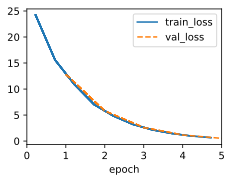

In [72]:
model = LinearRegression(lr=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2,num_train = 10000, num_val = 10000, batch_size = 512)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Below, we
[**compare the model parameters learned
by training on finite data
and the actual parameters**]
that generated our dataset.
To access parameters,
we access the weights and bias
of the layer that we need.
As in our implementation from scratch,
note that our estimated parameters
are close to their true counterparts.


(tensor([[-0.2847,  0.2324]]), tensor([-0.5651]))

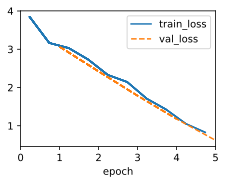

In [60]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
model.net.weight.grad, model.net.bias.grad

In [29]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0040, -0.0089])
error in estimating b: tensor([0.0114])


## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as Gluon `Chen.Li.Li.ea.2015`, 
JAX :cite:`Frostig.Johnson.Leary.2018`, 
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`, 
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it's generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the bleeding edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.


In PyTorch, the `data` module provides tools for data processing,
the `nn` module defines a large number of neural network layers and common loss functions.
We can initialize the parameters by replacing their values
with methods ending with `_`.
Note that we need to specify the input dimensions of the network.
While this is trivial for now, it can have significant knock-on effects
when we want to design complex networks with many layers.
Careful considerations of how to parametrize these networks
is needed to allow portability.


## Exercises

1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch
   with an average over the loss on the minibatch?
1. Review the framework documentation to see which loss functions are provided. In particular,
   replace the squared loss with Huber's robust loss function. That is, use the loss function
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \text{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \text{ otherwise}\end{cases}$$
1. How do you access the gradient of the weights of the model?
1. How does the solution change if you change the learning rate and the number of epochs? Does it keep on improving?
1. How does the solution change as you change the amount of data generated?
    1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1,000, 2,000, ..., 10,000.
    2. Why is the suggestion in the hint appropriate?


## Answer
1. We need to devide learn_rate by sample size of minibatch.
2. change `nn.MSELoss` to `nn.HuberLoss`
3. `model.parameters().grad` or model.net.weight.grad. However, this only gives the last gradients of fitting. How can we achieve each epochs' gradients?
4. No. Number of epochs won't make model more accurate. Large learning rate will have a nonconvergence performance.
5. Model performance seems to have a relationship with log(sample_size). However, I still can't figure out the reason. Maybe ML model equals to some kind of statistics estimation. The converge rate is important.


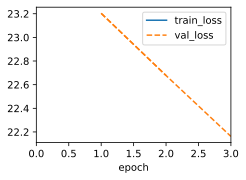

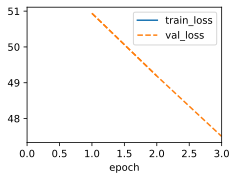

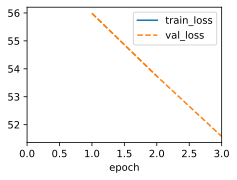

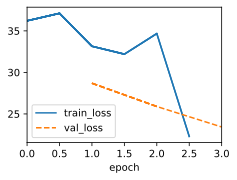

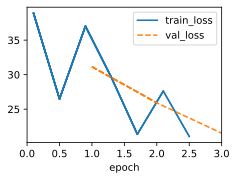

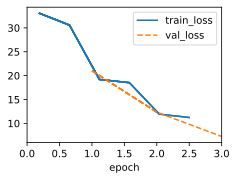

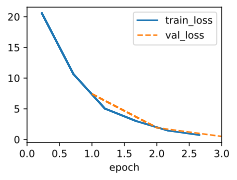

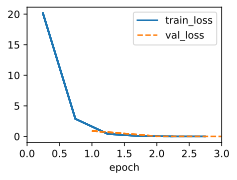

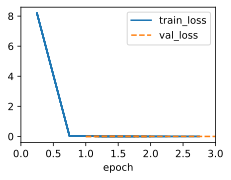

In [125]:
res = []
x = np.arange(1,10)
for sample_size in np.exp(x).round():
    model = LinearRegression(lr=0.01)
    data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2,num_train = int(sample_size), num_val = int(sample_size))
    trainer = d2l.Trainer(max_epochs=3)
    trainer.fit(model, data)
    w, b = model.get_w_b()
    res.append([data.w - w.reshape(data.w.shape), data.b - b])

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'estimation error vs. log(sample_size)')

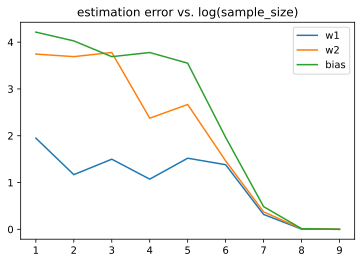

In [126]:
# x = np.arange(1,10)
plt.plot(x, [abs(i[0][0]) for i in res])
plt.plot(x, [abs(i[0][1]) for i in res])
plt.plot(x, [abs(i[1]) for i in res])
plt.legend(['w1', 'w2', 'bias'])
plt.title('estimation error vs. log(sample_size)')

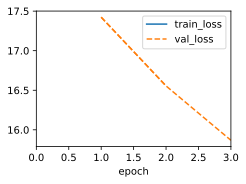

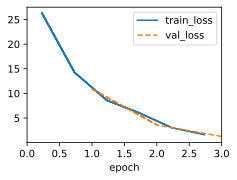

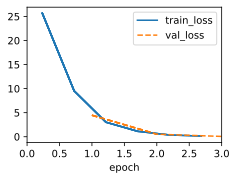

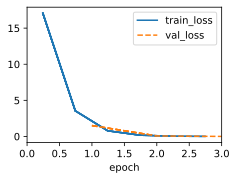

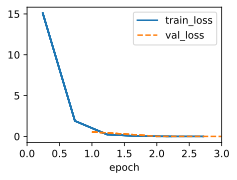

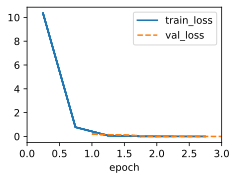

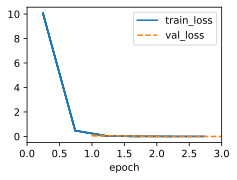

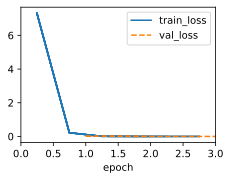

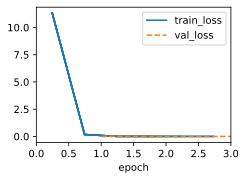

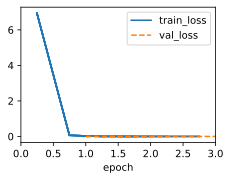

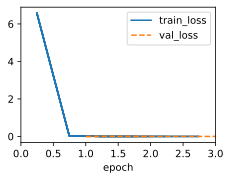

In [127]:
res = []
x = np.arange(1,8100, step = 800)
for sample_size in x.round():
    model = LinearRegression(lr=0.01)
    data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2,num_train = int(sample_size), num_val = int(sample_size))
    trainer = d2l.Trainer(max_epochs=3)
    trainer.fit(model, data)
    w, b = model.get_w_b()
    res.append([data.w - w.reshape(data.w.shape), data.b - b])

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'estimation error vs. sample_size')

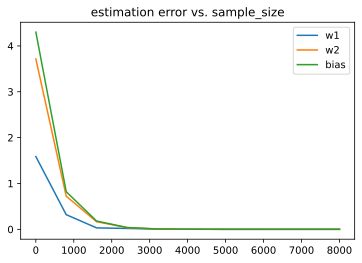

In [128]:
# x = np.arange(1,10)
plt.plot(x, [abs(i[0][0]) for i in res])
plt.plot(x, [abs(i[0][1]) for i in res])
plt.plot(x, [abs(i[1]) for i in res])
plt.legend(['w1', 'w2', 'bias'])
plt.title('estimation error vs. sample_size')

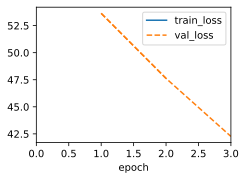

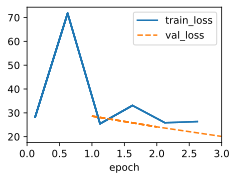

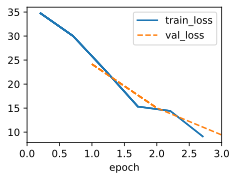

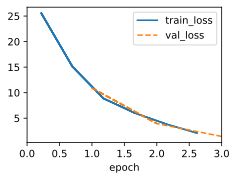

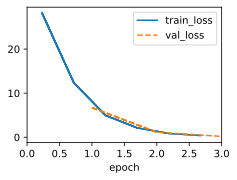

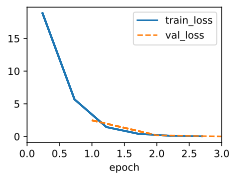

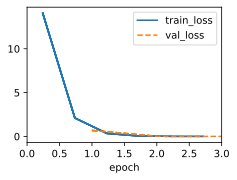

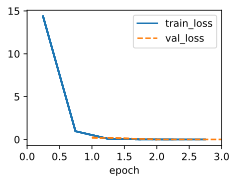

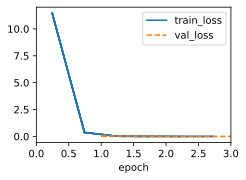

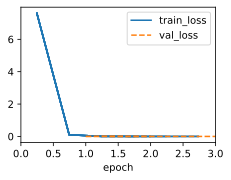

In [129]:
res = []
x = np.arange(1,90, step = 9)
for sample_size in x**2:
    model = LinearRegression(lr=0.01)
    data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2,num_train = int(sample_size), num_val = int(sample_size))
    trainer = d2l.Trainer(max_epochs=3)
    trainer.fit(model, data)
    w, b = model.get_w_b()
    res.append([data.w - w.reshape(data.w.shape), data.b - b])

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'estimation error vs. sqrt(sample_size)')

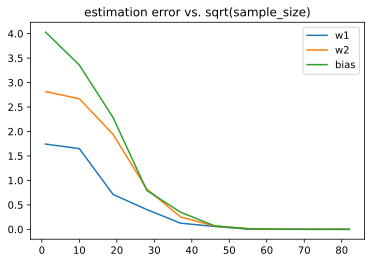

In [130]:
# x = np.arange(1,10)
plt.plot(x, [abs(i[0][0]) for i in res])
plt.plot(x, [abs(i[0][1]) for i in res])
plt.plot(x, [abs(i[1]) for i in res])
plt.legend(['w1', 'w2', 'bias'])
plt.title('estimation error vs. sqrt(sample_size)')

In [131]:
from scipy.stats import norm

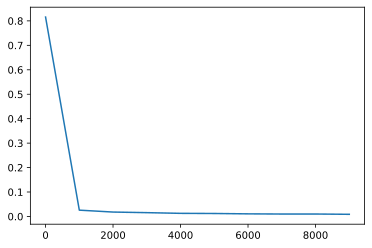

In [161]:
error = []
for n in np.arange(1,10000, step = 1000):
    res = 0
    for iter in range(100):
        res += abs(norm.rvs(2,1,n).mean() - 2)
    error.append(res/100)
plt.plot(np.arange(1,10000, step = 1000), error)

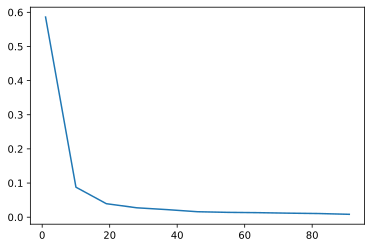

In [163]:
error = []
x = np.arange(1,10000, step = 1000)
for n in np.arange(1,94,9):
    res = 0
    for iter in range(100):
        res += abs(norm.rvs(2,1,n**2).mean() - 2)
    error.append(res/100)
plt.plot(np.arange(1,94,9), error)

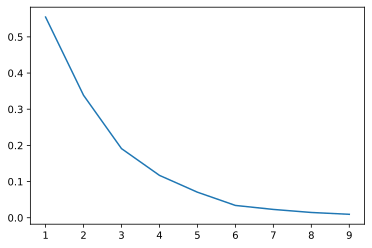

In [166]:
error = []
for n in np.arange(1,10,1):
    res = 0
    for iter in range(100):
        res += abs(norm.rvs(2,1,int(np.exp(n))).mean() - 2)
    error.append(res/100)
plt.plot(np.arange(1,10,1), error)

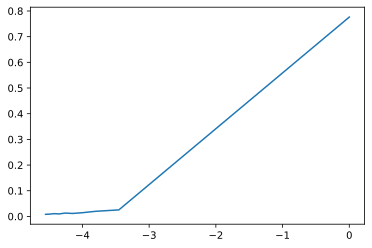

In [174]:
#  converge rate of estimation is 1/n**0.5
error = []
for n in np.arange(1,10000, step = 1000):
    res = 0
    for iter in range(100):
        res += abs(norm.rvs(2,1,n).mean() - 2)
    error.append(res/100)
plt.plot(np.log(1/np.arange(1,10000, step = 1000)**0.5), error)

In [172]:
np.arange(1,10000, step = 1000)**0.5

array([ 1.        , 31.63858404, 44.73253849, 54.7813837 , 63.2534584 ,
       70.71774883, 77.46612163, 83.67197858, 89.4483091 , 94.87360012])

[Discussions](https://discuss.d2l.ai/t/45)


94.86832980505137